In [1]:
# default_exp data.load_pd

In [2]:
# hide
import sys

sys.path.append("..")
import pandas as pd

/home/tako/dev/env37/lib/python3.7/site-packages/pandas/compat/__init__.py:117: UserWarning: Could not import the lzma module. Your installed Python is incomplete. Attempting to use lzma compression will result in a RuntimeError.
  warnings.warn(msg)


In [3]:
# export
from fastseq.core import *
from fastseq.data.external import *
from fastcore.utils import *
from fastcore.imports import *
from fastai2.basics import *
from fastai2.data.transforms import *
from fastai2.tabular.core import *

In [4]:
# hide
from nbdev.showdoc import *

# Data Load Dataframe


> Using the fastai2 `Datasets` to make an time series dataset.

A multivaraite time-series dataloader. 

TODO reduce mem: https://forums.fast.ai/t/how-to-handle-dataframes-too-large-to-fit-in-memory/39208/19

In [5]:
# export
import numpy as np
import pandas as pd

In [6]:
class TSeries(TensorBase):pass

In [7]:
def no_emp_dim(x):
    if len(x.shape)==1 :
        x = x[None,:]
    return np.vstack(x)

def show_graph(array, ax=None, figsize=None, title=None, ctx=None, tx=None, **kwargs):
    "Show an array on `ax`."
    if hasattrs(array, ('data','cpu','permute')):
        array = array.data.cpu()
    elif not isinstance(array,np.ndarray):
        array=array(array)
    arrays = no_emp_dim(array)
    ax = ifnone(ax,ctx)
    if figsize is None: figsize = (5,5)
    if ax is None: _,ax = plt.subplots(figsize=figsize)
    tx = ifnone(tx,np.arange(arrays[0].shape[0]))
    label = kwargs.pop('label', 'x')
    for a, c in zip(arrays, ['b', 'c', 'm', 'y', 'k',]):
        ax.plot(tx, a, '-*'+c,label=label, **kwargs)

    if title is not None: ax.set_title(title)

    ax.legend()
#     ax.axis('off')
    return ax

In [8]:
# export
class TensorSeqs(TSeries):
    
    def show(self, ax = None, ctx=None, **kwargs):
        ctx = ifnone(ctx, ax)
        if ctx is None: _, ctx = plt.subplots(figsize=(5,5))
        array = np.array(self.cpu())
        arrays = no_emp_dim(array)
        m = self._meta.get('m',['b', 'c', 'm', 'y', 'k',][:len(arrays)])
        labels = self._meta.get('label',['x']*len(arrays))
        t = np.arange(array.shape[1])
        
        for a, c, label in zip(arrays, m, labels):            
            mark = '-' if 'y' not in label else ''                
            ctx.plot(t, a, mark + '*' +c, **kwargs, label=label)            #
        ctx.legend()
        return ctx
    

In [9]:
a = torch.cat([i+torch.arange(10)[None,:] for i in [0,2]])

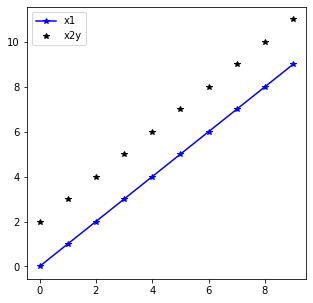

In [10]:
_, ctx = plt.subplots(figsize=[5,5])
ax = TensorSeqs(a, m=['b','k'], label = ['x1','x2y']).show(ctx=ctx)

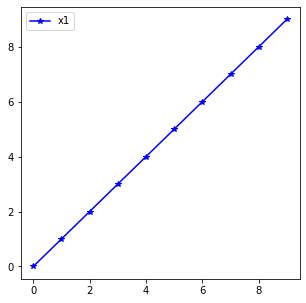

In [11]:
ax = TensorSeqs(torch.arange(10)[None,:], m=['b','k'], label = ['x1','x2']).show()

In [153]:
# export
class TensorCon(TSeries):
    def show(self, ax = None, ctx=None):
        ax = ifnone(ax,ctx)
        if ax is None:
            _, ax = plt.subplots(figsize=(5,5))
        ax.set_title(ax.title._text +f" {self._meta.get('label','con')}: {str(self.data.item())}")
        return ax

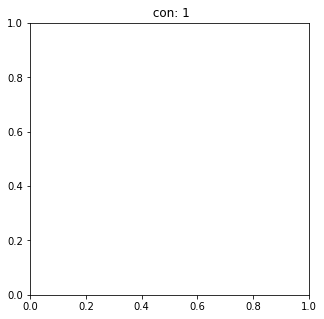

In [13]:
TensorCon(1).show()

## Utils

In [14]:
# export
from typing import List
def same_size_ts(ts:pd.Series, ts_names:List[str]):    
    all_same = [[(ts[c].shape == ts[a].shape) for c in ts_names] for a in ts_names]
    mask = np.array(all_same)    
    return np.sum(mask) == len(ts_names)**2
    

In [15]:
df = pd.DataFrame(data={'ts_0':[pd.Series(np.arange(10)),
                           pd.Series(np.arange(10))],
                   'ts_1':[pd.Series(np.arange(1,11)),
                           pd.Series(np.arange(1,12))],
                   'var_0':[0.,1.],
                   'con_0':[0,1]})
for i, row in df.iterrows():
    if i == 0:
        test_eq(same_size_ts(row,['ts_0','ts_1']),True)
    if i == 1:
        test_eq(same_size_ts(row,['ts_0','ts_1']),False)

In [16]:
# export
def get_part_of_ts(x, lookback_id, length, pad=np.mean):
    if len(x.shape) == 1:
        x = x[None,:]
    if isinstance(x[0,0],int):
        x = x.astype(float)
    if x.shape[-1] < length:
        # If the time series is too short, we pad
        padding = pad(x, -1)
        x = tensor(np.pad(
            x, # report issue https://github.com/numpy/numpy/issues/15606
            pad_width=((0, 0), (length - x.shape[-1], 0)),
            mode='constant',
            constant_values=padding
        )).float()
        assert x.shape == (x.shape[0],length), f"{x.shape}\t,{lookback_id}, 'tsshape':{x.shape}"
    else:
        x = tensor(x[:,lookback_id:lookback_id + length]).float()
    return x


In [17]:
x = np.arange(10)
test_eq(get_part_of_ts(x, 2, 5), torch.arange(2,7.)[None,:])
x = np.arange(10)[None,:]
test_eq(get_part_of_ts(x, 2, 5), torch.arange(2,7.)[None,:])
test_eq(get_part_of_ts(x, 0, 11), tensor([[4., 0, 1, 2, 3, 4, 5, 6, 7, 8, 9]]))
x = np.vstack([np.arange(10)]*2)
test_eq(get_part_of_ts(x, 2, 5), torch.cat([torch.arange(2,7.)[None,:]]*2))
test_eq(get_part_of_ts(x, 0, 11), tensor([[4., 0, 1, 2, 3, 4, 5, 6, 7, 8, 9],
                                          [4, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9]]))

# report issue https://github.com/numpy/numpy/issues/15606
x = np.arange(10)[None,:]
# test_eq(get_part_of_ts(x, 0, 11), tensor([[4.5, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9]]))

# Dataloader

In [191]:
# export
@delegates()
class DfDataLoader(TfmdDL):
    def __init__(self, dataset:pd.DataFrame, y_name:str, horizon:int, lookback=72, step=1, min_seq_len=None, max_std= 2, norm=True, **kwargs):
        store_attr(self,'horizon,lookback,step,max_std,norm,y_name')
        self.min_seq_len = ifnone(min_seq_len, lookback)
        self.dataset = dataset
        self.con_names, self.cat_names, self.ts_names = L(), L(), L()
        for col in dataset.columns:
            t = type(dataset[col].iloc[0])
            if t is pd.core.series.Series:
                self.ts_names.append(col)
            elif t is np.ndarray:
                self.dataset[col] = pd.Series([pd.Series(o.flatten()) for o in self.dataset[col]])
                self.ts_names.append(col)
            elif isinstance(dataset[col].iloc[0], int) or t is np.int64:
                self.con_names.append(col)
            elif isinstance(dataset[col].iloc[0], float):
                self.cat_names.append(col)
            else:
                raise Exception(t) 
        assert y_name in self.ts_names
        self.ts_names.remove(y_name)
        n = self.make_ids()
        super().__init__(dataset=self.dataset, **kwargs)
        self.n = n
        self.skipped= []
        self.ms = {}        

    @delegates(TfmdDL.new)
    def new(self, dataset=None, cls=None, **kwargs):
        res = super().new(dataset, cls, horizon=self.horizon, lookback=self.lookback, step=self.step , **kwargs)
        res.make_ids()
        return res

    def make_ids(self):
        """Make ids if the sequence is shorter than `min_seq_len`, it will drop that sequence."""
        # Slice each time series into examples, assigning IDs to each
        last_id = 0
        n_dropped = 0
        n_needs_padding = 0
        self._ids = {}
        for i, ts in self.dataset.iterrows(): 
            assert same_size_ts(ts, self.ts_names), f"row {i} are not all the time series the same length"
            num_examples = (ts[self.y_name].shape[-1] - self.lookback - self.horizon + self.step) // self.step
            # Time series shorter than the forecast horizon need to be dropped.
            if ts[self.y_name].shape[-1] < self.min_seq_len:
                n_dropped += 1
                continue
            # For short time series zero pad the input
            if ts[self.y_name].shape[-1] < self.lookback + self.horizon:
                n_needs_padding += 1
                num_examples = 1
            for j in range(num_examples):
                self._ids[last_id + j] = (i, j * self.step)
            last_id += num_examples

        # Inform user about time series that were too short
        if n_dropped > 0:
            print("Dropped {}/{} time series due to length.".format(
                    n_dropped, len(self.dataset)))

        # Inform user about time series that were short
        if n_needs_padding > 0:
            print("Need to pad {}/{} time series due to length.".format(
                    n_needs_padding, len(self.dataset)))
        # Store the number of training examples
        return int(self._ids.__len__() )
    
        def shuffle_fn(self, idxs):
#         self.dataset.shuffle()        
            return idxs

    def get_id(self, idx):
        ts_id, lookback_id = self._ids[idx]
        row = self.dataset.iloc[ts_id, :]
        x = get_part_of_ts(row[self.y_name].values, lookback_id, self.lookback)        
        y = get_part_of_ts(row[self.y_name].values, lookback_id, self.lookback + self.horizon)
        tsx = np.concatenate([o[None,:] for o in row[self.ts_names].to_numpy()])
        tsx = get_part_of_ts(tsx, lookback_id, self.lookback + self.horizon)
        r = [TensorSeqs(x, label=[self.y_name + '_x'], m=['g']), 
             TensorSeqs(tsx,label=self.ts_names)]
        if len(self.cat_names):
            r.append(TensorCon(row[self.cat_names].to_numpy().astype(float),label=self.cat_names))
        if len(self.con_names):
            # TODO make cat its own type
            r.append(TensorCon(row[self.con_names].to_numpy().astype(float),label=self.con_names))            
        # TODO make y its own type
        r.append(TensorSeqs(y, label=[self.y_name+ '_y'], m=['r']))
        return Tuple(r)

    def create_item(self, idx):
        if idx>=self.n:
            raise IndexError
        r  = self.get_id(idx)
        if (r[-1]/(r[0].std()+1e-7)).std() > self.max_std:
            if idx not in self.skipped:
#                 print(f"idx: {idx};y.std to high: {(y/x.std()).std()} > {self.max_std}")
                self.skipped.append(idx)
            raise SkipItemException()
              
        return r
    

The data will be stored in pandas DataFrames. This can be use for time series by nesting series into a cell. An example is shown below: 

In [206]:
df = pd.DataFrame(data={'pred':[np.arange(10.),
                           np.arange(12.)],
                   'ts_0':[np.ones(10)[None,:],
                           np.ones(12)[None,:]],
                   'ts_1':[pd.Series(np.arange(1,11)+np.random.randn(10)),
                           pd.Series(np.arange(1,13)+np.random.randn(12))],
                   'var_0':[0.,1.],
                   'con_0':[0,1]})
df

,pred,ts_0,ts_1,var_0,con_0
0,"[0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0]","[[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]]",0 0.937520 1 2.857837 2 4.101018 3 4.546103 4 4.637165 5 6.375385 6 7.968388 7 10.302457 8 7.017184 9 9.628763 dtype: float64,0.0,0
1,"[0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 11.0]","[[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]]",0 0.552035 1 1.064634 2 1.510431 3 4.847707 4 6.673099 5 4.681533 6 5.555976 7 9.180665 8 8.316546 9 8.790270 10 11.580207 11 11.095992 dtype: float64,1.0,1


In [207]:
horizon,lookback = 2,9
dl = DfDataLoader(df, 'pred', horizon = horizon, lookback = lookback)


Need to pad 1/2 time series due to length.


In [208]:
for o in dl:
    dct = {k:v for k,v in zip(['x','tsx','cat','con','y'],o)}
    print({k:v.shape for k,v in dct.items()})
    test_eq(dct['x'].shape,(3,1,9))
    break
dl.ts_names

{'x': torch.Size([3, 1, 9]), 'tsx': torch.Size([3, 2, 11]), 'cat': torch.Size([3, 1]), 'con': torch.Size([3, 1]), 'y': torch.Size([3, 1, 11])}


(#2) ['ts_0','ts_1']

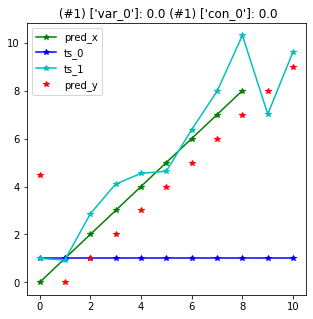

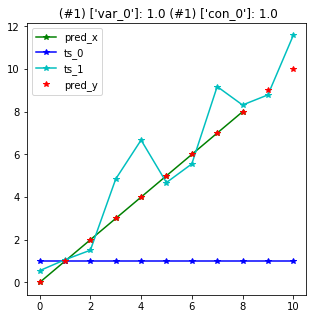

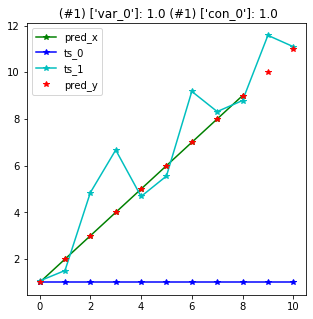

In [209]:
dl.show_batch(max_n=3)

In [216]:
# hide
# without cat or con
horizon,lookback = 2,9
dl = DfDataLoader(df[['pred','ts_0']], 'pred', horizon = horizon, lookback = lookback)


for o in dl:
    dct = {k:v for k,v in zip(['pred','ts_0','y'],o)}
    print({k:v.shape for k,v in dct.items()})
    test_eq(dct['ts_0'].shape, dct['y'].shape)
    test_eq(dct['pred'].shape[1:],(1,9))
    break


Need to pad 1/2 time series due to length.
{'pred': torch.Size([3, 1, 9]), 'ts_0': torch.Size([3, 1, 11]), 'y': torch.Size([3, 1, 11])}


# Intergration Example

In [217]:
from fastseq.data.external import *

In [220]:
horizon,lookback = 5,10
df = dummy_data_generator_multi(32)
df.head()

,x,weather,city,cont
0,"[[-2.413739210416185, -2.2564903268022545, -2.031405850544832, -1.7063768624239535, -1.3434396644903117, -1.0511719304629776, -0.6663176524684123, -0.1818718574586486, 0.28923587940178325, 0.5263361686627472, 0.584176529676796, 0.5440645335023947, 0.5111941431086424, 0.4018843059229617, 0.194521608184543, 0.23092946959921326, 0.0635122137117286, 0.03792063130069202, 0.1382020552919892, -0.08001341476678167, -0.05940002821586135, -0.08437349954825077, 0.028733352239152667, 0.15580365827210657, 0.510841670732469, 0.6583227368067123, 0.8546051647509493, 1.0709398210822012, 1.1245884866761142,...","[[8.963863044727377, 8.547874273014617, 8.431190036119203, 8.709804296572408, 9.346605041697387, 10.174490579869016, 10.945140823086764, 11.407570910244491, 11.389867195988437, 10.856066509049457, 9.918550346996275, 8.801649595055176, 7.768997461868835, 7.0395935352677785, 6.72118607205876, 6.783199643406357, 7.077344263633964, 7.39727635475476, 7.555197715826626, 7.447826139204366, 7.088604995708509, 6.595649428491119, 6.1411419341839775, 5.8818228068268645, 5.89686049279509, 6.1563779805903245, 6.532394092225785, 6.848129852566614, 6.947297560509783, 6.757368083092919, 6.32270919244459, ...",0,-2.426283
1,"[[-2.052971131619912, -2.1063891735240756, -1.8822799820814218, -1.6740461695551783, -0.8751479504156455, 0.08668372183611936, 0.5834303143725618, 1.108038250089971, 1.7988803543838543, 1.5288083175476446, 0.7882767958044744, 0.6958711225736088, 0.4155100529049403, 0.24401902518727314, 0.01075362091392405, 0.5389719295612119, 0.4070546735482444, 0.751772793902191, 0.6357365414245144, 0.3193738876771531, -0.4326422296224497, -0.8459606080593572, -0.8804668739720121, -1.1782345519210713, -0.8537020260051261, -0.3098064149328359, 0.21112790521605276, 0.3695381653193705, 1.0051050348993953, 0....","[[3.863995509329097, 3.6273626429872308, 3.5151054269453565, 3.5595586809762687, 3.768037126247174, 4.1205227372721085, 4.571812880204668, 5.057825947462501, 5.50508424393489, 5.841874096345179, 6.009304990074876, 5.970498332043375, 5.716431078640544, 5.267492546356922, 4.670498209113604, 3.991631456101569, 3.306435650234099, 2.6884491678314424, 2.198289497728826, 1.874914612532848, 1.730433524997968, 1.7492610981898005, 1.8917083512518664, 2.101382759888594, 2.315159475593039, 2.4740732687644513, 2.5333387454030105, 2.469855766679387, 2.285973472198603, 2.0089020048641686, 1.6858757832931...",0,-0.987222
2,"[[-1.055960104280439, -0.8803226911836215, -0.9167773699891724, -0.9919334427089954, -1.3730412190210206, -1.2739259122756121, -1.4113997945237458, -1.3304480273214891, -1.6307190155478057, -1.0382226507043417, -0.8869521731064973, -0.27394724688725464, 0.32614382521217095, 0.7262857274668882, 1.3171956538207226, 1.5660496992270292, 1.1052103833700817, 1.3819191229980157, 0.8305923574560659, 0.4104705151722876, 0.17956242675616188, -0.011023519366946061, -0.30658855161451054, -0.3685845045738515, 0.016981217857865098, -0.20286083669241106, 0.48268395308747825, 0.42048677998217715, 0.962820...","[[6.437714575869124, 6.5524281022864965, 6.740092131813089, 6.956946438359944, 7.147795885488216, 7.265900152275709, 7.28986813950268, 7.2314951644782495, 7.131726599475725, 7.046187022737897, 7.0254538191827045, 7.097137873265132, 7.256186292190361, 7.466875164720921, 7.675770577244591, 7.831005367421627, 7.900956417334035, 7.885623726981822, 7.816630414282983, 7.7458436415772285, 7.726697322476815, 7.794915368219206, 7.955550671599221, 8.180992348161874, 8.420663012989205, 8.61893808783845, 8.734872200436303, 8.756670033473634, 8.705722686170175, 8.628770479448152, 8.581008549746368, 8.6...",0,-1.324464
3,"[[-0.4279703907363975, -0.3969214330328346, -0.5911917305020576, -0.6087111808194636, 0.17838843945150168, 0.14382120500063755, 0.5212482645444075, 0.4521219400161031, 0.15813599912167575, -0.3478764891422753, -1.140133720543554, -1.5868318120258733, -1.9528376521812938, -1.9899832671096644, -1.5006553524198603, -0.39096

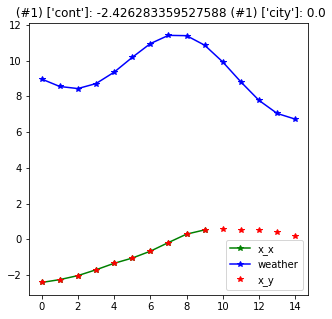

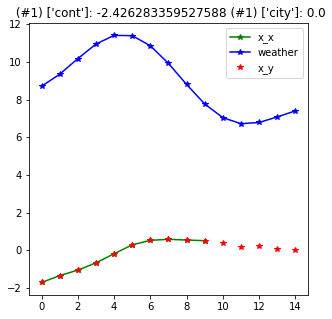

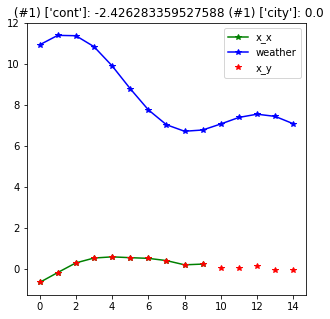

In [221]:
dl = DfDataLoader(df, 'x', horizon = horizon, lookback = lookback, step=3)
dl.show_batch(max_n=3)

In [222]:
# hide
from nbdev.export import *

notebook2script()

Converted 00_core.ipynb.
Converted 01_data.external.ipynb.
Converted 020_data.load_pd.ipynb.
Converted 02_data.load.ipynb.
Converted 03_data.core.ipynb.
Converted 03_data.core_pd.ipynb.
Converted 050_nbeats.models_multi.ipynb.
Converted 05_nbeats.models.ipynb.
Converted 06_nbeats.callbacks.ipynb.
Converted 07_nbeats.learner.ipynb.
Converted 08_nbeats.interpret.ipynb.
Converted 11_metrics.ipynb.
Converted 12_compare.ipynb.
Converted index.ipynb.
